In [1]:
import json
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import collections
import numpy as np

# Data

In [2]:
with open("movielens/saturation/users.json", "r") as f:
    user_ids = json.load(f)
print(user_ids)

[3501, 70691, 122780, 69353, 74069, 29330, 83325, 42971, 100206, 64094, 14549, 8512, 110161, 8388, 54160, 15961]


In [3]:
ratings = pd.read_csv('../data/rating.csv').rename(columns={"userId": 'u_id',  "movieId": "i_id"})
movies = pd.read_csv('../data/movie.csv').rename(columns={"movieId": "i_id"})
genres = pd.DataFrame({k: {g: True for g in v} for k, v in movies.set_index('i_id').genres.apply(lambda gs: gs.split("|")).to_dict().items()}).fillna(False).transpose()

In [4]:
ratings.head()

,u_id,i_id,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [5]:
movies.head()

,i_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
genres.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
1,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# Analysie selected users

In [7]:
GENRE1 = "Action"
GENRE2 = "Romance"

In [8]:
rat_sel = ratings[ratings.u_id.isin(user_ids)]
rat_sel

,u_id,i_id,rating,timestamp
517084,3501,10,3.0,1996-11-19 16:25:09
517085,3501,150,4.0,1996-11-19 16:21:57
517086,3501,153,2.0,1996-11-19 16:22:45
517087,3501,161,5.0,1996-11-19 16:25:09
517088,3501,165,5.0,1996-11-19 16:22:45
...,...,...,...,...
17759560,122780,58559,3.5,2010-03-25 02:20:06
17759561,122780,60487,5.0,2010-03-25 02:21:06
17759562,122780,64575,4.5,2010-03-25 02:15:36
17759563,122780,66934,4.5,2010-03-25 02:18:13


Number of ratings posted:

In [9]:
rat_sel.groupby('u_id').count().i_id

u_id
3501        26
8388        21
8512        31
14549      243
15961       56
29330       32
42971      146
54160     1318
64094      252
69353       76
70691       24
74069       22
83325       31
100206      78
110161      57
122780      37
Name: i_id, dtype: int64

User genre interests:

In [10]:
user_genres = pd.merge(rat_sel, genres.reset_index().rename(columns={'index': 'i_id'}), on='i_id', how='left').groupby('u_id').sum().drop(['rating', 'i_id'], axis=1)

In [11]:
(user_genres.transpose() / user_genres.transpose().sum() * 100).transpose().round(1)

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
u_id,,,,,,,,,,,,,,,,,,,,
3501,13.1,2.4,2.4,8.3,1.2,6.0,10.7,16.7,8.3,15.5,0.0,0.0,7.1,2.4,0.0,2.4,2.4,1.2,0.0,0.0
8388,7.7,1.9,1.9,23.1,1.9,9.6,19.2,7.7,3.8,5.8,0.0,1.9,5.8,0.0,0.0,1.9,1.9,5.8,0.0,0.0
8512,12.0,0.0,0.0,10.8,2.4,7.2,13.3,20.5,9.6,10.8,3.6,1.2,7.2,0.0,0.0,1.2,0.0,0.0,0.0,0.0
14549,9.6,2.1,2.7,13.0,4.9,8.9,19.7,10.4,6.5,8.1,0.9,2.1,3.6,3.0,0.9,1.8,1.0,0.7,0.1,0.0
15961,6.7,3.0,2.2,19.4,6.7,5.2,19.4,6.0,6.7,6.0,0.7,3.0,6.7,0.7,3.0,3.7,0.0,0.7,0.0,0.0
29330,6.6,3.3,0.0,14.3,2.2,0.0,11.0,9.9,12.1,13.2,6.6,8.8,6.6,0.0,0.0,1.1,1.1,1.1,2.2,0.0
42971,10.4,0.5,0.7,7.2,1.9,3.4,13.3,15.2,3.9,9.4,3.6,1.4,20.2,0.0,0.2,6.3,1.0,0.5,1.0,0.0
54160,4.7,0.9,1.2,14.4,2.3,7.0,22.2,8.1,9.0,12.7,3.6,4.1,4.1,0.2,1.6,1.6,1.0,0.7,0.5,0.0
64094,10.4,3.2,2.6,11.5,4.7,3.9,14.0,12.3,6.2,9.4,2.2,2.6,9.1,1.0,1.1,2.4,2.2,0.7,0.4,0.0


Initial saturation:

In [12]:
(user_genres.transpose() / user_genres.transpose().sum() * 100).round(1).transpose()[[GENRE1, GENRE2]]

,Action,Romance
u_id,,
3501,16.7,6.0
8388,7.7,9.6
8512,20.5,7.2
14549,10.4,8.9
15961,6.0,5.2
29330,9.9,0.0
42971,15.2,3.4
54160,8.1,7.0
64094,12.3,3.9


In [13]:
genres_id = genres.reset_index().rename(columns={'index': 'i_id'})

# Saturation

In [14]:
satur_files = os.listdir('movielens/saturation')

In [15]:
satur_data = {}

for sf in satur_files:
    if re.match("predictions", sf):
        data_tmp = pd.read_parquet(f'movielens/saturation/{sf}')
        index_tmp = int(sf.split("_")[-1].split(".")[0])
        satur_data[index_tmp] = data_tmp #  pd.merge(data_tmp, genres_id, how='left', on='i_id')

Example from saved data frames:

In [16]:
data_tmp

,u_id,i_id,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,...,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed),pred
0,3501,2,True,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,3.728563
1,70691,2,True,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,2.806835
2,122780,2,True,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,3.449394
3,69353,2,True,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,3.130522
4,74069,2,True,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,3.388352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424777,8512,110510,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,3.721760
424778,110161,110510,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,3.303899
424779,8388,110510,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,3.427680
424780,54160,110510,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,4.358375


Number of records in saved data frames (of ratings for selected users and available movies)

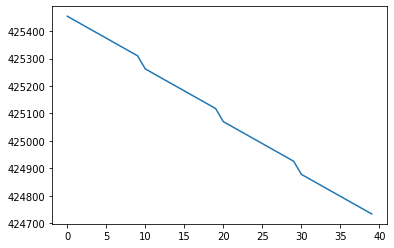

In [17]:
plt.plot(pd.Series(collections.OrderedDict(sorted({k: v.shape[0] for k, v in satur_data.items()}.items()))))
plt.show()

## Saturation 1

Saturation in 100 best new recommendations

In [18]:
satur1 = {}
for k, v in satur_data.items():
    satur1[k] = v.groupby("u_id").apply(
        lambda df: df.sort_values("pred")[-100:].drop(["u_id", "i_id", "pred"], axis=1).mean())
satur1df = pd.concat(satur1)

In [19]:
satur1df.sort_index()

Adventure  Animation  Children  Comedy  Fantasy  Romance  Drama  \
   u_id                                                                      
0  3501         0.08       0.01      0.01    0.22     0.02     0.15   0.50   
   8388         0.16       0.02      0.00    0.33     0.07     0.06   0.36   
   8512         0.00       0.00      0.00    0.26     0.00     0.15   0.45   
   14549        0.03       0.03      0.00    0.23     0.01     0.09   0.51   
   15961        0.12       0.13      0.07    0.35     0.08     0.08   0.34   
...              ...        ...       ...     ...      ...      ...    ...   
39 74069        0.01       0.00      0.01    0.30     0.02     0.38   0.69   
   83325        0.07       0.12      0.07    0.44     0.03     0.27   0.40   
   100206       0.06       0.00      0.01    0.27     0.06     0.31   0.70   
   110161       0.06       0.04      0.01    0.29     0.07     0.36   0.71   
   122780       0.03       0.00      0.00    0.18     0.01     0.36   0.83   

           Action  Crime  Thriller  Horror  Mystery  Sci-Fi  IMAX  \
   u_id                                                             
0  3501      0.13   0.10      0.09    0.02     0.04    0.04  0.03   
   8388      0.24   0.20      0.17    0.00     0.07    0.10  0.05   
   8512      0.03   0.07      0.10    0.01     0.06    0.00  0.00   
   14549     0.02   0.10      0.03    0.00     0.06    0.01  0.00   
   15961     0.12   0.08      0.11    0.01     0.06    0.07  0.01   
...           ...    ...       ...     ...      ...     ...   ...   
39 74069     0.02   0.03      0.01    0.01     0.03    0.01  0.03   
   83325     0.08   0.10      0.04    0.01     0.02    0.02  0.00   
   100206    0.03   0.04      0.05    0.02     0.03    0.00  0.00   
   110161    0.03   0.08      0.07    0.00     0.03    0.04  0.01   
   122780    0.02   0.07      0.02    0.00     0.05    0.02  0.01   

           Documentary   War  Musical  Western  Film-Noir  (no genres listed)  
   u_id                                                                        
0  3501           0.28  0.09     0.02     0.00       0.01                0.00  
   8388           0.25  0.05     0.05     0.01       0.00                0.00  
   8512           0.31  0.09     0.01     0.00       0.00                0.00  
   14549          0.34  0.04     0.00     0.00       0.00                0.00  
   15961          0.28  0.10     0.03     0.00       0.00                0.00  
...                ...   ...      ...      ...        ...                 ...  
39 74069          0.14  0.07     0.05     0.00       0.00                0.00  
   83325          0.16  0.07     0.07     0.04       0.01                0.00  
   100206         0.17  0.03     0.06     0.00       0.00                0.01  
   110161         0.13  0.04     0.04     0.00       0.00                0.00  
   122780         0.11  0.14     0.03     0.01       0.00                0.00  

[640 rows x 20 columns]

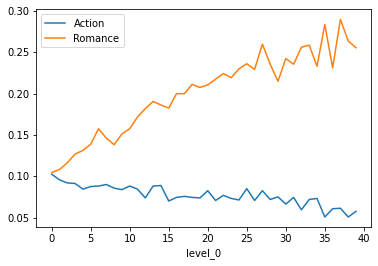

In [20]:
satur1df.sort_index()[[GENRE1, GENRE2]].reset_index().groupby('level_0').mean().plot(y=[GENRE1, GENRE2])
plt.show()

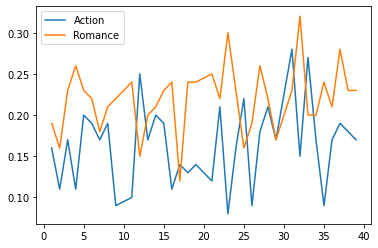

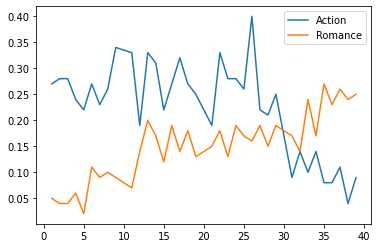

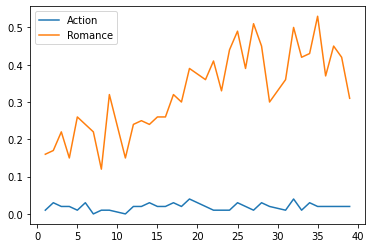

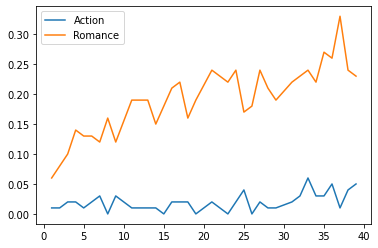

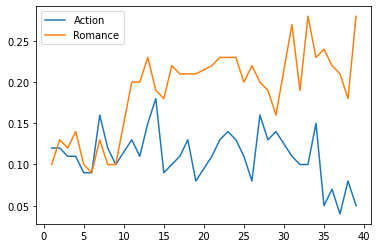

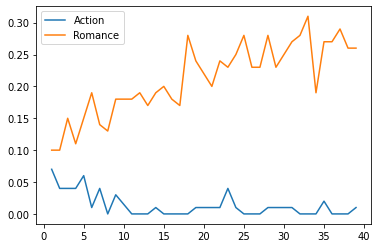

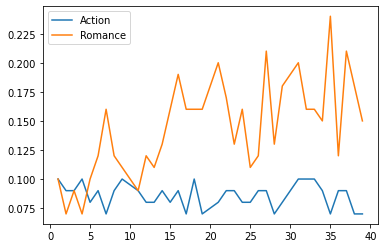

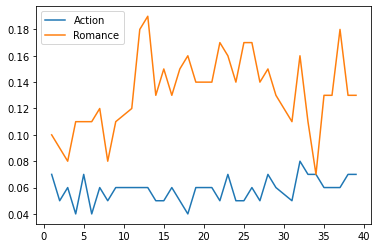

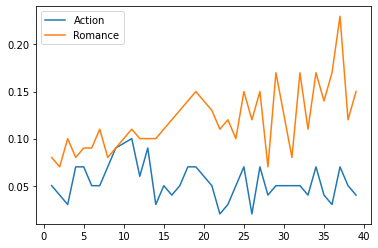

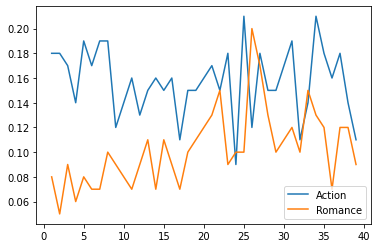

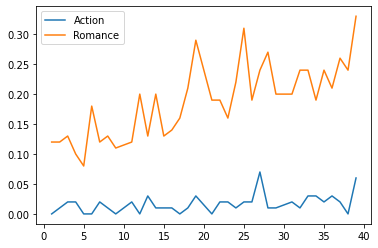

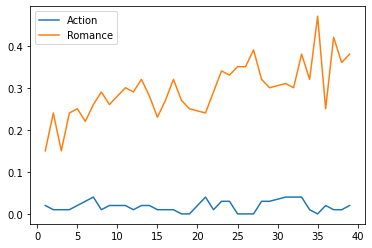

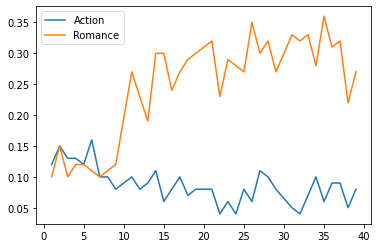

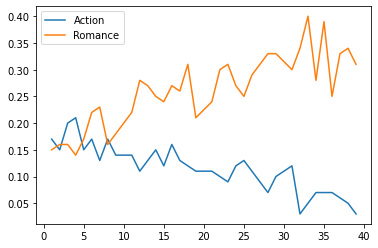

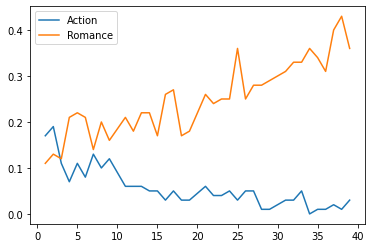

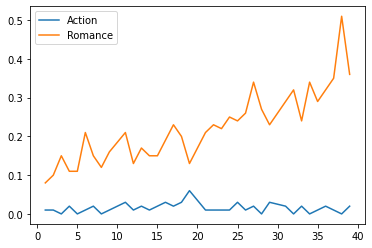

In [21]:
satur1df.sort_index()[[GENRE1, GENRE2]].reset_index(level=1).groupby('u_id').apply(lambda df:  df.loc[df.index  % 10  != 0, :].plot(y=[GENRE1, GENRE2]))
plt.show()

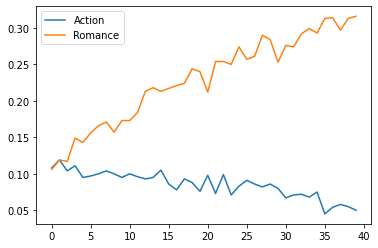

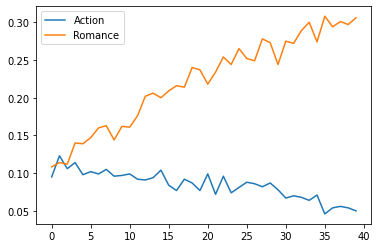

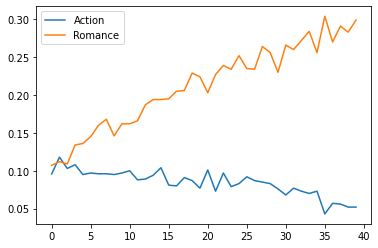

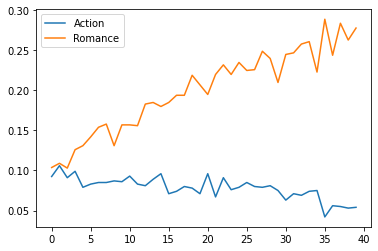

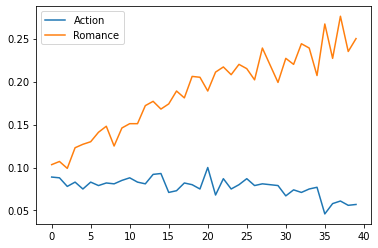

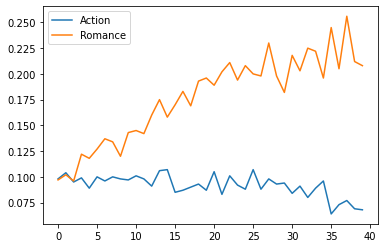

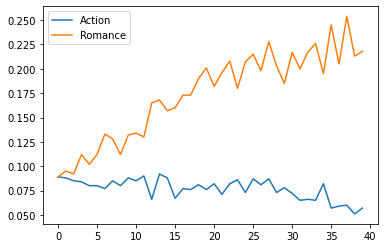

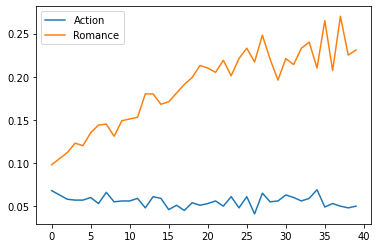

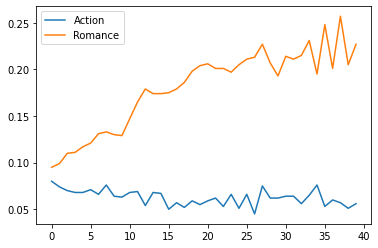

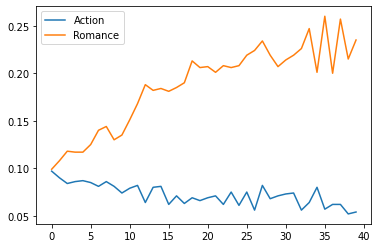

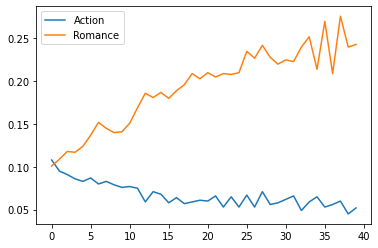

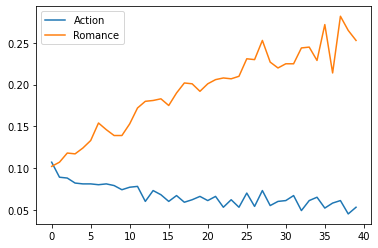

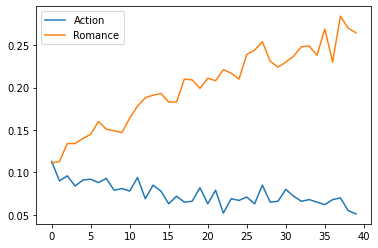

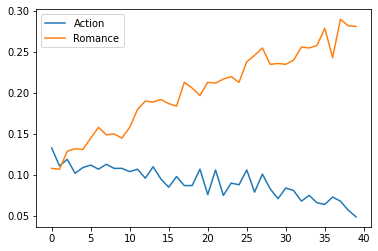

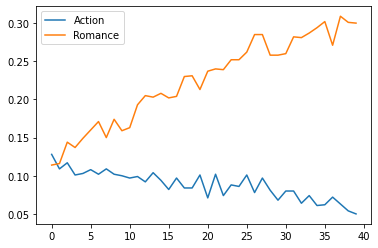

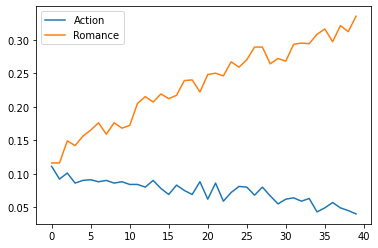

In [22]:
satur1df.sort_index()[[GENRE1, GENRE2]].rolling(10, center=True, min_periods=1).mean().reset_index(level=1).groupby('u_id').plot(y=[GENRE1, GENRE2])
plt.show()

# Analyse mean ratings of reccomended movies

In [23]:
def saturation3(df):
    df_selected = df.sort_values("pred")[-100:]
    # selected = [df_selected.groupby(g)['pred'].mean() for g in [GENRE1, GENRE2]]
    selected = [df_selected.groupby(g)['pred'].mean() for g in ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance',
       'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi',
       'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir']]
    return [s[True] if True in s.keys() else 0 for s in selected]

In [24]:
satur3 = {}
for k, v in satur_data.items():
    # satur3[k] = pd.DataFrame(v.groupby("u_id").apply( saturation3).to_dict(), index = [GENRE1, GENRE2])
    satur3[k] = pd.DataFrame(v.groupby("u_id").apply( saturation3).to_dict(), index = ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance',
       'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi',
       'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir'])

In [25]:
satur3df = pd.concat(satur3)
satur3dff =satur3df.reset_index(level=0).groupby('level_0').apply(lambda df: df.transpose())

<AxesSubplot:xlabel='level_1'>

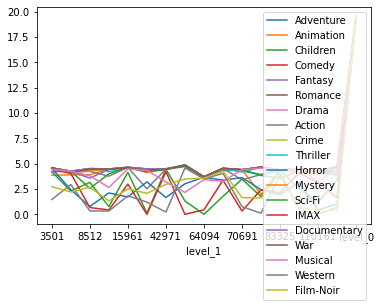

In [26]:
satur3dff.sort_index()[['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance',
       'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi',
       'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir']].reset_index().groupby('level_1').mean().plot(y=['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance',
       'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi',
       'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir'])


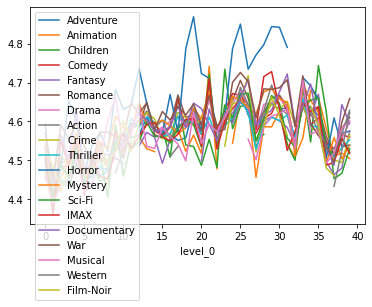

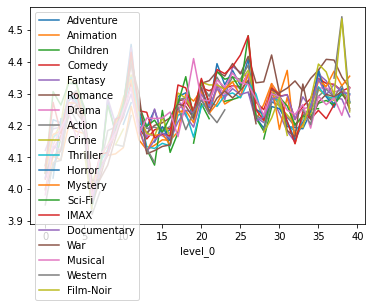

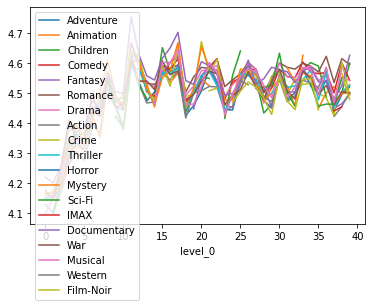

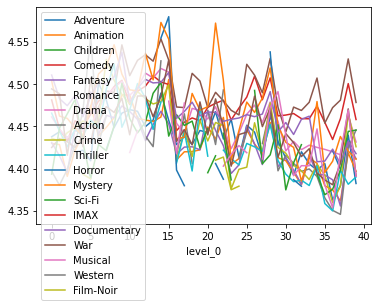

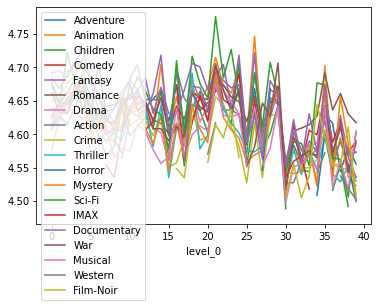

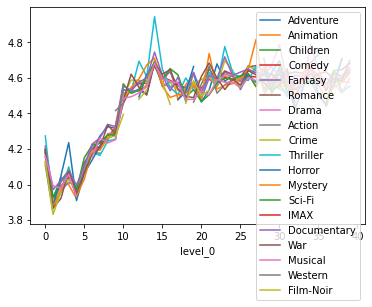

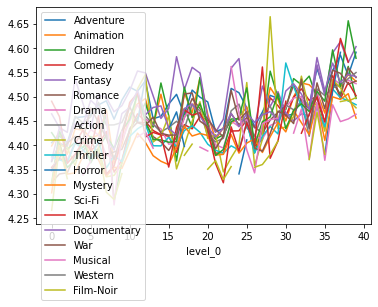

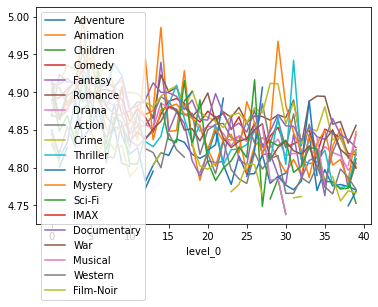

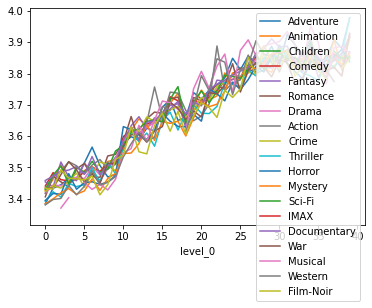

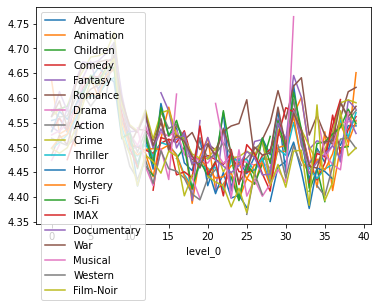

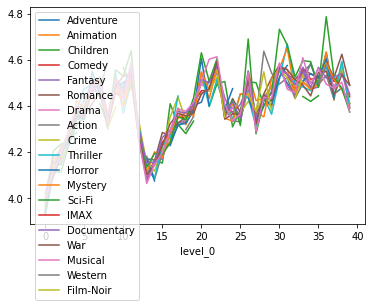

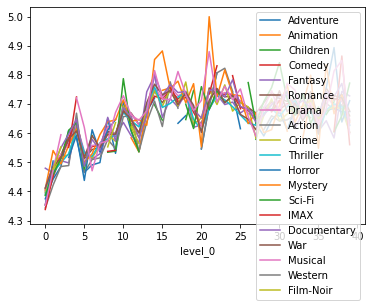

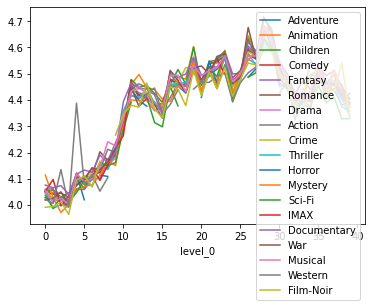

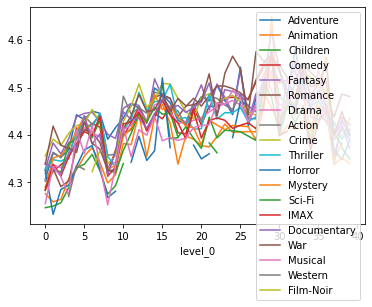

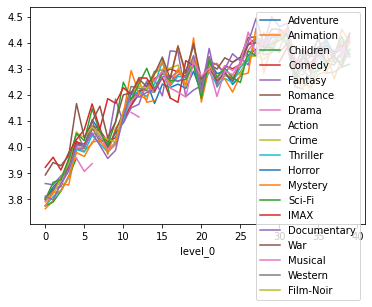

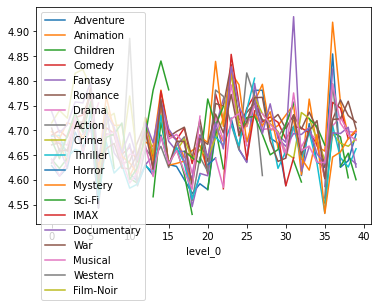

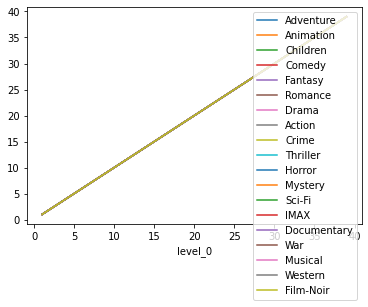

In [27]:
satur3dff.sort_index()[['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance',
       'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi',
       'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir']].reset_index(level=1).groupby('level_1').apply(
    lambda df: df.replace(0, np.nan).plot(y=['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance',
       'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi',
       'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir']))
plt.show()